*This notebook was created by Sergey Tomin (sergey.tomin@desy.de). Source and license info is on [GitHub](https://github.com/ocelot-collab/ocelot). May 2020.*

### Appendix: some useful OCELOT functions

This notebook was created to show some small functions that may be useful for accelerator physicists.
### Contents
1. [Aperture](#aperture)
2. [Losses along accelerator lattice](#losses)
3. [RK tracking](#rk)
4. [How to save/dump the beam distribution at a specific location of the lattice](#savebeam)
5. [Energy jitter. Or simulation of the jitter in the RF parameters.](#jitter)
6. [Get Twiss parameters from the beam slice](#twiss)
7. [Transfer Maps in Ocelot. Global assignment and for specific elements](#TM)

In [1]:
# import modules
from ocelot import *
from ocelot.gui.accelerator import *
import copy
import pandas as pd
import seaborn as sbn
import time
import matplotlib.pyplot as plt

initializing ocelot...


## Aperture
<a id='aperture'></a>

Suppose you have a simple (and imposible) missaligned dump beam line. 
And you want to know the best corrector setting to get 100% transmission. 

We are goring to explor the transmission in horizontal only. 

#### Lattice 

In [2]:
d = Drift(l=1)

# horizontal correctors
c1 = Hcor()
c2 = Hcor()

# Sextupoles
sf = Sextupole(l=0.2, k2=3000)
sf.dx, sf.dy = 1e-3, -1e-3

sd = Sextupole(l=0.2, k2=-3000)
sd.dx, sd.dy = 1e-3, -1e-3


# Quadrupoles with transversal offsets
qf = Quadrupole(l=0.2, k1=1, k2=20)
qf.dx, qf.dy = 1e-3, -1e-3

qd = Quadrupole(l=0.2, k1=-1, k2=-20, tm=SecondTM)
qd.dx, qd.dy = -1e-3, 1e-3

# Collimators
ap1 = Aperture(xmax=5e-3, dx=-1e-3)
ap2 = Aperture(xmax=5e-3, dx=1e-3)
# BPMs
m1 = Monitor()
m2 = Monitor()

# Solenoids
solb_23_i1 = Solenoid(eid='SOLB.23.I1')
cell = (d, c1, d, sf, d, qf, d, ap1, d, m1, d, c2, d, sd, d, qd, d, ap2, d, m2, d,)

lat = MagneticLattice(cell, method={"global": SecondTM})

Create ParticleArray and Navigator objects

In [3]:
p_array_init = generate_parray(sigma_x=1e-3, sigma_px=5e-5, sigma_y=1e-3, sigma_py=5e-5, 
                               nparticles=20000, charge=1e-09, energy=1.)

correctors = [c1, c2]



#### function to calculate transmission through the lattice

In [4]:
def transmission(lat, navi, correctors, kicks):
    for i, kick in enumerate(kicks):
        correctors[i].angle = kick
    
    lat.update_transfer_maps()
    
    # reset position of the Navigator 
    navi.reset_position()
    
    p_array = copy.deepcopy(p_array_init)
    tws_tack, p_array = track(lat, p_array, navi, calc_tws=False, print_progress=False)
    trans = p_array.n / p_array_init.n
    return trans


def scan(cor1_range, cor2_range):
    trans_response = np.zeros((len(cor2_range), len(cor1_range)))

    for i, a2 in enumerate(A2):
        print(f"{i} of {len(A2)}", end="\r")
        for j, a1 in enumerate(A1):
            kicks = [a1, a2]
            trans_response[i, j] = transmission(lat, navi, correctors, kicks)
    
    return trans_response

### Scan with two correctors. Apertures are NOT activated. 
Here we expect 100% transmission for any corrector settings.

 exec n_tracks=612:  32.27504515647888 s


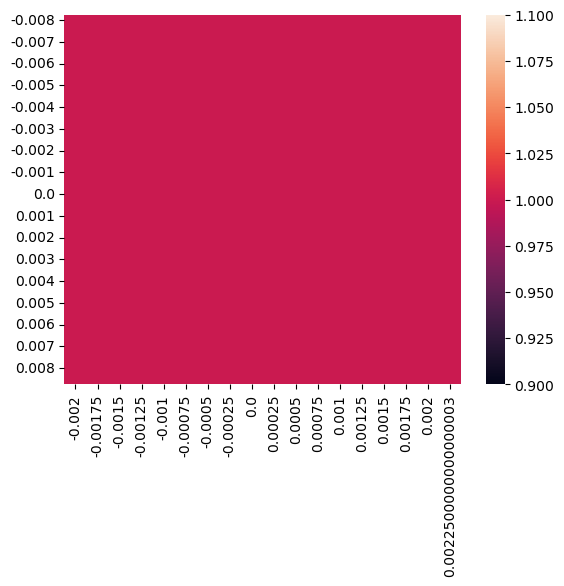

In [5]:
navi = Navigator(lat)

A1 = np.arange(-2, 2.5, 0.25)*1e-3
A2 = np.arange(-8, 9., 0.5)*1e-3

start = time.time()

trans_response = scan(A1, A2)

print(f" exec n_tracks={len(A2) * len(A1)}:  {time.time() - start} s")
df = pd.DataFrame(trans_response, index=A2, columns=A1)
sbn.heatmap(df)
plt.show()

### Scan with two correctors. Apertures are activated. 

 exec n_tracks=612:  39.902544260025024 s


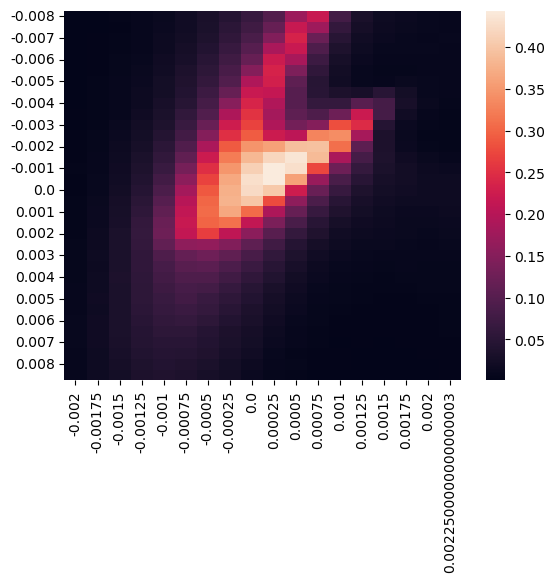

In [6]:
navi = Navigator(lat)

# activate apertures
navi.activate_apertures()

# activate apertures starting from element "start" up to element "stop"
# navi.activate_apertures(start=None, stop=m1)

start = time.time()

trans_response = scan(A1, A2)

print(f" exec n_tracks={len(A2) * len(A1)}:  {time.time() - start} s")
df = pd.DataFrame(trans_response, index=A2, columns=A1)
sbn.heatmap(df)
plt.show()

## Losses along accelerator lattice
<a id='losses'></a>


New feature which is available currently in dev branch.

```ParticleArray``` has ```lost_particle_recorder atribute``` (```LostParticleRecorder```) has list of  s_positions along accelerator and number of particles which were lost at that point

```p_array.lost_particle_recorder.lp_to_pos_hist = [(s1, n_lost_particles), (s2, n_lost_particlse), ..., (sn, n_lost_particlse)]```

transmission:  0.4235


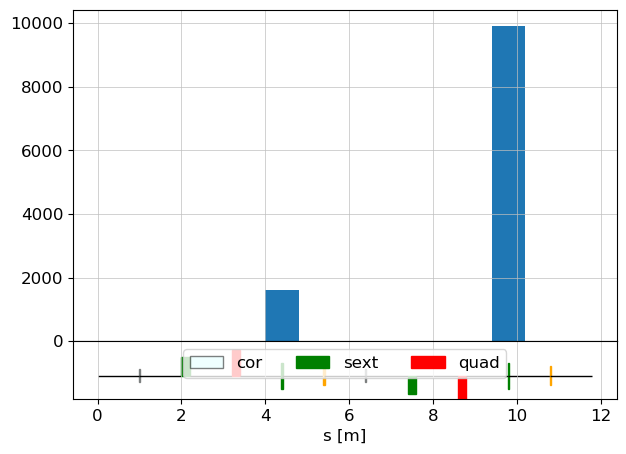

In [7]:
navi = Navigator(lat)

# activate apertures
navi.activate_apertures()

c1.angle = 0
c2.angle = 0

lat.update_transfer_maps()
    
# reset position of the Navigator 
navi.reset_position()
    
p_array = copy.deepcopy(p_array_init)
tws_tack, p_array = track(lat, p_array, navi, calc_tws=False, print_progress=False)
trans = p_array.n / p_array_init.n
print("transmission: ", trans)

s = [p[0] for p in p_array.lost_particle_recorder.lp_to_pos_hist]
nlost = [p[1] for p in p_array.lost_particle_recorder.lp_to_pos_hist]

fig, ax_xy = plot_API(lat, legend=True, fig_name=10)
ax_xy.bar(s, nlost)
plt.show()


## Tracking the electron beam with Runge-Kutta integrator in magnetic fields
<a id='rk'></a>




In OCELOT, there is a possibility to track the beam in the arbitrary defined 3D magnetic fields. 

You need two components to do this: 
1. define the 3D magnetic fields 
2. MethodTM, the class which creates Transfer Maps, should know that you want to apply RK integrator to an element

### define 3D Magnetic fields. 

In [8]:
lperiod = 0.01 # [m] undulator period 
nperiods = 50  # number of periods
Kx = 2         # undulator deflection parameter


def und_field_3D(x, y, z, lperiod, Kx):
    kx = 0.
    kz = 2 * pi / lperiod
    ky = np.sqrt(kz * kz + kx * kx)
    c = speed_of_light
    m0 = m_e_eV
    B0 = Kx * m0 * kz / c
    k1 = -B0 * kx / ky
    k2 = -B0 * kz / ky

    kx_x = kx * x
    ky_y = ky * y
    kz_z = kz * z

    cosz = np.cos(kz_z)

    cosx = np.cos(kx_x)
    sinhy = np.sinh(ky_y)
    Bx = k1 * np.sin(kx_x) * sinhy * cosz 
    By = B0 * cosx * np.cosh(ky_y) * cosz
    Bz = k2 * cosx * sinhy * np.sin(kz_z)
    return (Bx, By, Bz)


# define number of points along z-axis, by default npoints = 200
und = Undulator(lperiod=lperiod, nperiods=nperiods, Kx=Kx, eid="und", npoints = 500)
und.mag_field = lambda x, y, z: und_field_3D(x, y, z, lperiod=lperiod, Kx=Kx)

### Create MagneticLattice and MethodTM

In [9]:
from ocelot.cpbd.transformations import RungeKuttaTM
d = Drift(l=0.5)
qf = Quadrupole(l=0.2, k1=1.2)
qd = Quadrupole(l=0.2, k1=-1.2)

#method = MethodTM()
# let the MethodTM to know
#method.params[Undulator] = RungeKuttaTM


lat = MagneticLattice((d, qf, d, qd, d, und, d, qf, d, qd, d), 
                      method={"global": SecondTM, Undulator: RungeKuttaTM})

### Tracking through the lattice WITH RK integrator

In [10]:
p_array = copy.deepcopy(p_array_init)

navi = Navigator(lat)

tws_track, _ = track(lat, p_array, navi)



z = 4.3 / 4.300000000000001. Applied: 0001. Applied: 

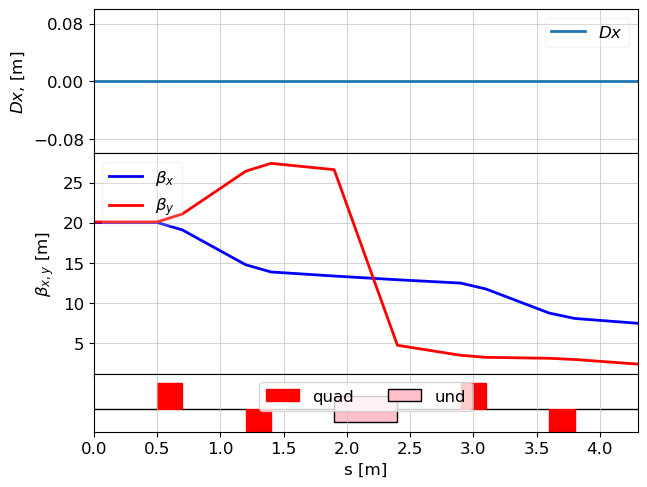

In [11]:
plot_opt_func(lat, tws_track)
plt.show()

### Tracking through the lattice WITHOUT RK integrator 

z = 4.3 / 4.300000000000001. Applied: 0001. Applied: 

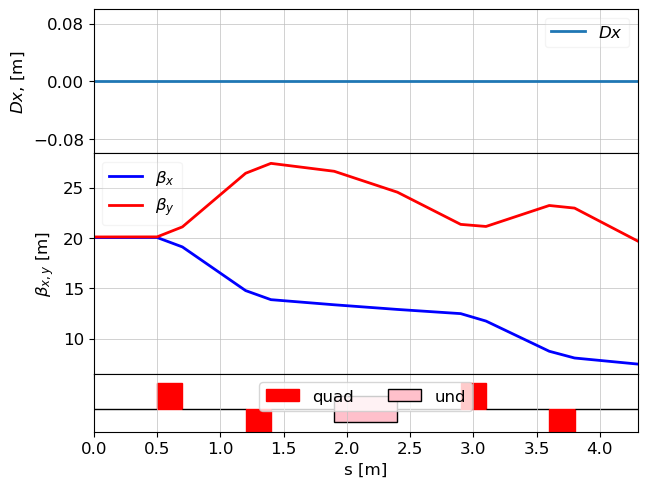

In [12]:
d = Drift(l=0.5)
qf = Quadrupole(l=0.2, k1=1.2)
qd = Quadrupole(l=0.2, k1=-1.2)


lat = MagneticLattice((d, qf, d, qd, d, und, d, qf, d, qd, d), method={"global":SecondTM})
p_array = copy.deepcopy(p_array_init)

navi = Navigator(lat)

tws_track, _ = track(lat, p_array, navi)

plot_opt_func(lat, tws_track)
plt.show()

## Dump the beam distribution at a specific location of the lattice
<a id='savebeam'></a>

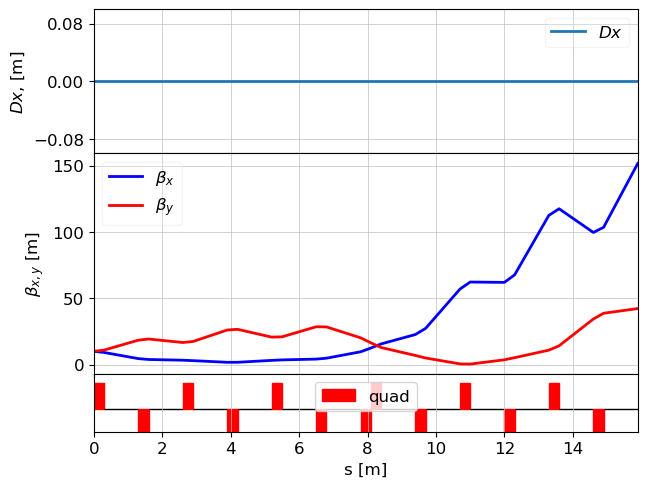

In [13]:

from ocelot import *
from ocelot.gui import *

# define elements of the lattice
d = Drift(1.)
qf = Quadrupole(l=0.3, k1=1)
qd = Quadrupole(l=0.3, k1=-1)
m = Marker()
fodo = (qf, d, qd, d)
cell = (fodo*3, m, qd, fodo*3)

# init MagneticLattice
lat = MagneticLattice(cell)

# calc twiss
tws0 = Twiss()
tws0.beta_x = 10
tws0.beta_y = 10
tws = twiss(lat, tws0)
plot_opt_func(lat, tws)

### Tracking

In [14]:
# generate ParticleArray
parray = generate_parray(tws=tws[0])

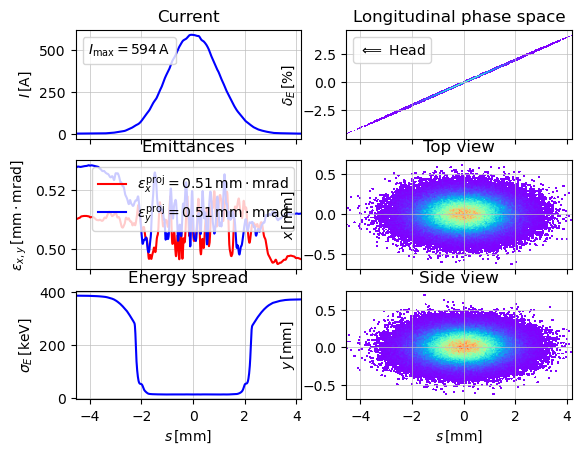

In [15]:
show_e_beam(parray)

z = 15.9 / 15.900000000000004. Applied: 004. Applied: 

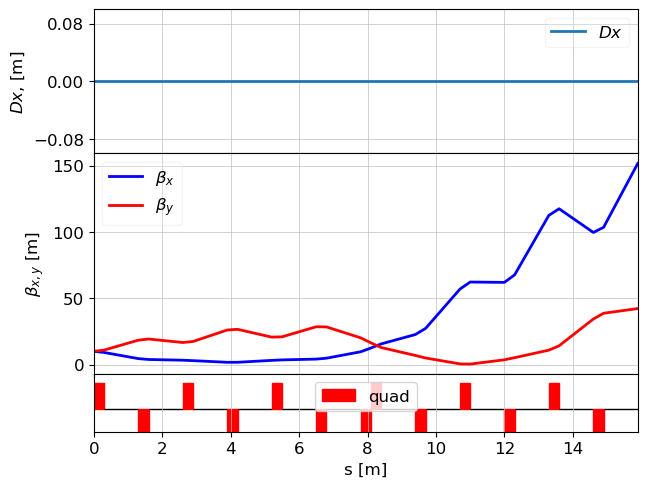

In [16]:
from ocelot.cpbd.physics_proc import SaveBeam
navi = Navigator(lat)

# define SaveBeam 
sv = SaveBeam(filename="test.npz")
navi.add_physics_proc(sv, m, m)

tws_track, _ = track(lat, parray, navi)

plot_opt_func(lat, tws_track)


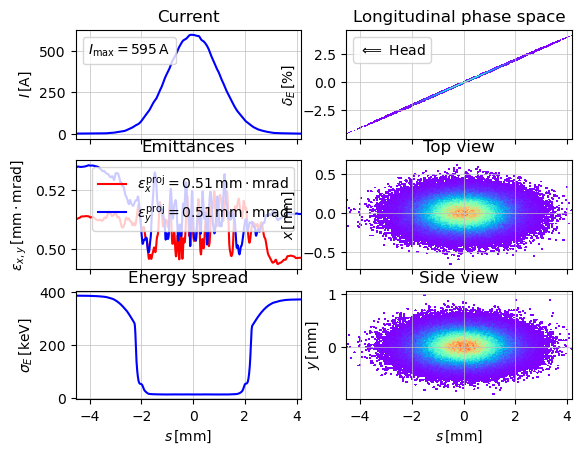

In [17]:
parray_dump = load_particle_array("test.npz")
show_e_beam(parray_dump)

### CopyBeam
The same idea to dump the particle array but not on a hard disc but rather to the memory. 
The usage is similar:
```
cb = CopyBeam()
navi.add_physics_proc(cb, m, m)

parray_copied = cb.parray
```



## Energy jitter. Or simulation of the jitter in the RF parameters
<a id='jitter'></a>

*This notebook was created as a response to an open [issue](https://github.com/ocelot-collab/ocelot/issues/142) on GitHub, October 2022*

In [18]:
# import modules
from ocelot import *
from ocelot.gui.accelerator import *
from ocelot.utils import *
import copy

I reuse some part of the ["Tutorial N9. Simple accelerator based THz source"](https://nbviewer.org/github/ocelot-collab/ocelot/blob/master/demos/ipython_tutorials/9_thz_source.ipynb) but remove undulator, simplified cavities and added additional cavity and new bunch compressor. 

Note the Twiss parameters are not optimize and we are not interested in transverse dynamics. 

### Lattice

[INFO    ] Twiss parameters have priority. sigma_{x, px, y, py} will be redefined


beam energy after the gun:  0.005


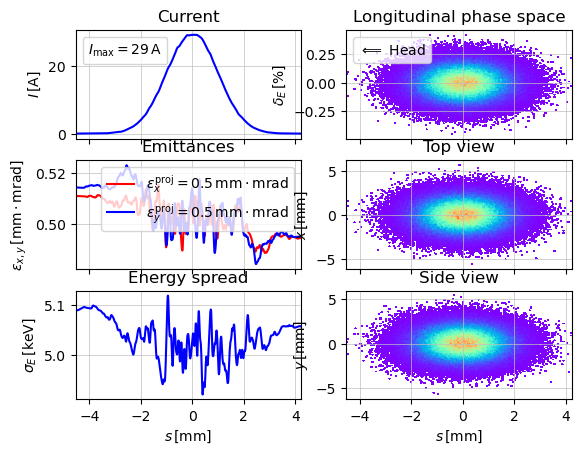

In [19]:
Egun = 0.005
gamma = Egun/m_e_GeV
beta = np.sqrt(1 - gamma**-2)
#Initial Twiss parameters
tws0 = Twiss()
tws0.emit_x = 0.5e-6/gamma/beta
tws0.emit_y = 0.5e-6/gamma/beta
tws0.beta_x = 29.171
tws0.beta_y = 29.171
tws0.alpha_x = 10.955
tws0.alpha_y = 10.955
tws0.gamma_x = 4.148367385417024
tws0.gamma_y = 4.148367385417024
tws0.E = Egun

parray_init = generate_parray(sigma_tau=0.001, sigma_p=1e-3, charge=250e-12,
                              chirp=0, tws=tws0)
show_e_beam(parray_init)
print("beam energy after the gun: ", parray_init.E)

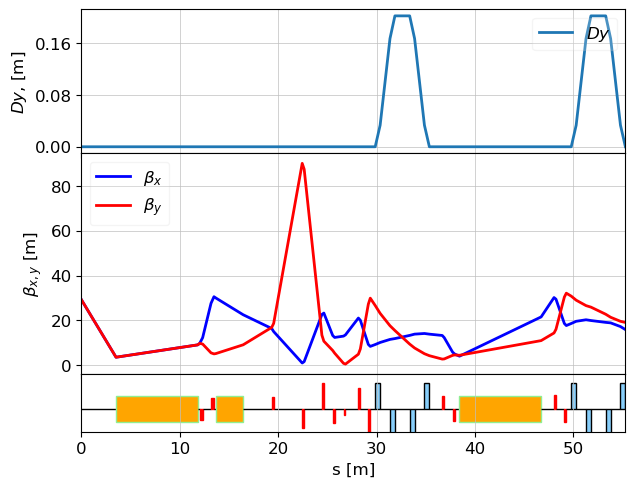

In [20]:
Egun = 0.005
gamma = Egun/m_e_GeV
beta = np.sqrt(1 - gamma**-2)
#Initial Twiss parameters
tws0 = Twiss()
tws0.emit_x = 0.5e-6/gamma/beta
tws0.emit_y = 0.5e-6/gamma/beta
tws0.beta_x = 29.171
tws0.beta_y = 29.171
tws0.alpha_x = 10.955
tws0.alpha_y = 10.955
tws0.gamma_x = 4.148367385417024
tws0.gamma_y = 4.148367385417024
tws0.E = Egun

# Drifts
D0 = Drift(l=3.52)
D1 = Drift(l=0.3459)
D2 = Drift(l=0.2043)
D3 = Drift(l=0.85)
D4 = Drift(l=0.202)
D5 = Drift(l=0.262)
D6 = Drift(l=2.9)
D8 = Drift(l=1.8)
D9 = Drift(l=0.9)
D11 = Drift(l=1.31)
D12 = Drift(l=0.81)
D13 = Drift(l=0.50)
D14 = Drift(l=1.0)
D15 = Drift(l=1.5)
D18 = Drift(l=0.97)
D19 = Drift(l=2.3)
D20 = Drift(l=2.45)


# Quadrupoles
q1 = Quadrupole(l=0.3, k1=-1.537886, eid='Q1')
q2 = Quadrupole(l=0.3, k1=1.435078, eid='Q2')
q3 = Quadrupole(l=0.2, k1=1.637, eid='Q3')
q4 = Quadrupole(l=0.2, k1=-2.60970, eid='Q4')
q5 = Quadrupole(l=0.2, k1=3.4320, eid='Q5')
q6 = Quadrupole(l=0.2, k1=-1.9635, eid='Q6')
q7 = Quadrupole(l=0.2, k1=-0.7968, eid='Q7')
q8 = Quadrupole(l=0.2, k1=2.7285, eid='Q8')
q9 = Quadrupole(l=0.2, k1=-3.4773, eid='Q9')
q10 = Quadrupole(l=0.2, k1=0.780, eid='Q10')
q11 = Quadrupole(l=0.2, k1=-1.631, eid='Q11')
q12 = Quadrupole(l=0.2, k1=1.762, eid='Q12')
q13 = Quadrupole(l=0.2, k1=-1.8, eid='Q13')
q14 = Quadrupole(l=0.2, k1=1.8, eid='Q14')
q15 = Quadrupole(l=0.2, k1=-1.8, eid='Q15')


# SBends
b1 = SBend(l=0.501471120927, angle=0.1327297047, e2=0.132729705, tilt=1.570796327, eid='B1')
b2 = SBend(l=0.501471120927, angle=-0.1327297047, e1=-0.132729705, tilt=1.570796327, eid='B2')
b3 = SBend(l=0.501471120927, angle=-0.1327297047, e2=-0.132729705, tilt=1.570796327, eid='B3')
b4 = SBend(l=0.501471120927, angle=0.1327297047, e1=0.132729705, tilt=1.570796327, eid='B4')

# Cavitys
c1 = Cavity(l=1.0377*8, v=0.1547, phi=24.625, freq=1300000000.0, eid='C1')
c13 = Cavity(l=0.346*8, v=0.0158, phi=188.68, freq=3900000000.0, eid='C3')
c2 = Cavity(l=1.0377*8, v=0.57/np.cos(30*np.pi/180), phi=30, freq=1300000000.0, eid='C1')

m_i1_end = Marker("I1End")
m_l1_end = Marker("L1End")
# Lattice 
cell = (D0, c1, D2, q1, D3, q2, D4, c13, D6, q3, 
        m_i1_end,
        D6, q4, D8, q5, D9, q6, D9, q7, D11, q8, D12, q9, D13, b1, D14, b2, D15, b3, 
        D14, b4, D11, q12, D3, q11,D13, c2, m_l1_end, D11, q14, D3, q13,
        D13, b1, D14, b2, D15, b3,D14, b4, )

lat = MagneticLattice(cell)

tws = twiss(lat, tws0)
plot_opt_func(lat, tws, top_plot=["Dy"], legend=False, fig_name=100)
plt.show()

### Track beam without any errors in the RF system

z = 55.299268967416005 / 55.29926896741601. Applied: 

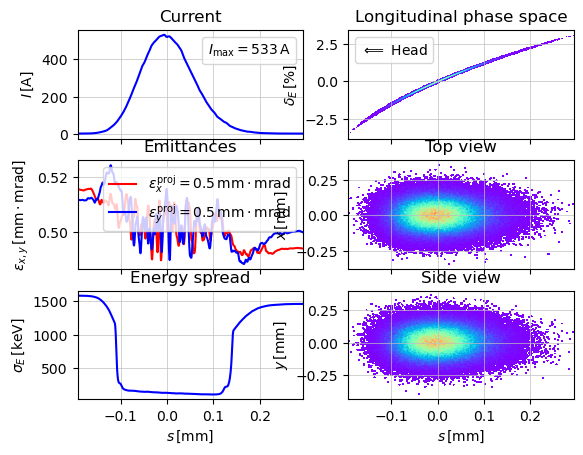

ParticleArray: 
Ref. energy : 0.7 GeV 
Ave. energy : 0.7 GeV 
std(x)      : 0.076 mm
std(px)     : 0.008 mrad
std(y)      : 0.084 mm
std(py)     : 0.006 mrad
std(p)      : 0.0075
std(tau)    : 0.056 mm
Charge      : 0.25 nC 
s pos       : 55.29926896741601 m 
n particles : 200000



In [21]:
parray = copy.deepcopy(parray_init)
#cb = CopyBeam()

navi = Navigator(lat)
#navi.add_physics_proc(cb, m_i1_end,m_i1_end)
tws_track, parray = track(lat, parray, navi)
show_e_beam(parray, nfig=201)
plt.show()
print(parray)

### Introduce errors in the RF system
let's suppose we have errors in phase 0.1 deg in all cavities. 
And we track the beam without any modifications in the lattice. However we will have a look on the beam energy after injector and last accelerator. In ideal machine the energies should be 130 MeV and 700 MeV. 

z = 55.299268967416005 / 55.29926896741601. Applied: opyBeam

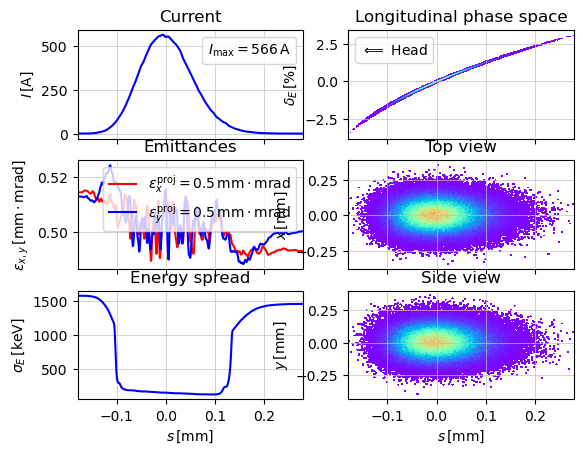

beam energy after third harmonic: 0.12989482081125267
beam energy after the last cavity: 0.6993195831447575


In [22]:
c1.phi = 24.625 + 0.1
c13.phi = 188.68 - 0.1
c2.phi = 30 + 0.1

parray = copy.deepcopy(parray_init)

navi = Navigator(lat)

cb1 = CopyBeam()
cb2 = CopyBeam()

navi.add_physics_proc(cb1, m_i1_end, m_i1_end)
navi.add_physics_proc(cb2, m_l1_end, m_l1_end)

tws_track, parray = track(lat, parray, navi)
show_e_beam(parray, nfig=201)
plt.show()
print(f"beam energy after third harmonic: {cb1.parray.E}")
print(f"beam energy after the last cavity: {cb2.parray.E}")

First, we can clearly see that the amplitude of the beam current has changed, which is not surprising. 
And secondly, that the beam gains slightly different energy in the two accelerator stages.
The property ```E``` in object ```ParticleArray``` is resposible for the calculation of the beam reference energy. 

In OCELOT there is no reference energy for the magnets. This means that the magnets will now "act" as if they were instantly tuned to the new reference energy. And this is not how it happens in real accelerator.

To overcome this a new Physics Process ```LatticeEnergyProfile``` was introduced.



### Define energy profile

The ```LatticeEnergyProfile``` class has an attribute which is a reference energy ```Eref```. The object just shift 6th coordinate in a ParticleArray according to a new reference energy. 

z = 55.299268967416005 / 55.29926896741601. Applied: atticeEnergyProfile, CopyBeam

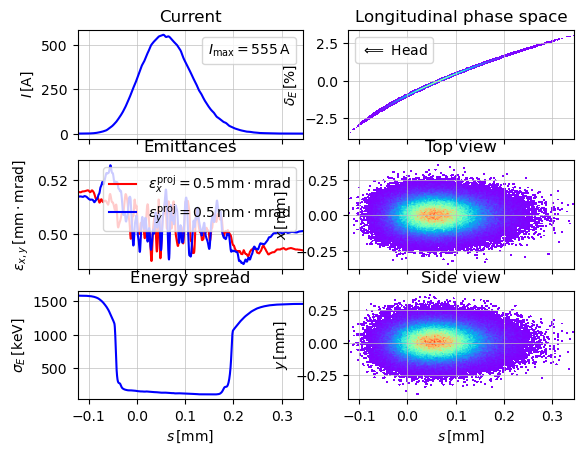

beam energy after third harmonic: 0.13
beam energy after the last cavity: 0.7


In [23]:
from ocelot.cpbd.physics_proc import LatticeEnergyProfile

navi = Navigator(lat)
e_prof1 = LatticeEnergyProfile(Eref=0.13)
e_prof2 = LatticeEnergyProfile(Eref=0.7)
navi.add_physics_proc(e_prof1, m_i1_end, m_i1_end)
navi.add_physics_proc(e_prof2, m_l1_end, m_l1_end)
cb1 = CopyBeam()
cb2 = CopyBeam()

navi.add_physics_proc(cb1, m_i1_end, m_i1_end)
navi.add_physics_proc(cb2, m_l1_end, m_l1_end)


parray = copy.deepcopy(parray_init)
tws_track, parray = track(lat, parray, navi)
show_e_beam(parray, nfig=201)
plt.show()
print(f"beam energy after third harmonic: {cb1.parray.E}")
print(f"beam energy after the last cavity: {cb2.parray.E}")

As a result we see that the beam energy after accelerations are again 130 MeV and 700 MeV. And amplitude of the beam current is again different.

### Simple test
This procedure should not change the mean energy of the beam. Let's check.

The 6th coordinate is 
$$
p = \frac{E - E_0}{p_0 c}
$$
where
$$
p_0 c = \sqrt{E_0^2 - m_0^2 c^4}
$$
So
$$
E = p  p_0 c + E_0
$$

In [24]:
parray_test = generate_parray(energy=0.5)
p0c = np.sqrt(parray_test.E**2 - m_e_GeV**2)
Emean0 = np.mean(parray_test.p()*p0c + parray_test.E)
print(Emean0)

0.49999583531188


let's change the reference energy

In [25]:
e_profile_test = LatticeEnergyProfile(Eref = 0.505)
e_profile_test.apply(parray_test)
print(parray_test)

ParticleArray: 
Ref. energy : 0.505 GeV 
Ave. energy : 0.5 GeV 
std(x)      : 0.1 mm
std(px)     : 0.02 mrad
std(y)      : 0.1 mm
std(py)     : 0.02 mrad
std(p)      : 0.0099
std(tau)    : 1.001 mm
Charge      : 5.0 nC 
s pos       : 0.0 m 
n particles : 200000



In [26]:
p0c = np.sqrt(parray_test.E**2 - m_e_GeV**2)
Emean1 = np.mean(parray_test.p()*p0c + parray_test.E )
print(Emean1)
print(Emean0 == Emean1)

0.49999583531188
True


## Get Twiss parameters from the beam slice 
<a id='twiss'></a>
*October 2022*

In [27]:
# import modules
from ocelot import *
from ocelot.gui.accelerator import *
from ocelot.utils import *
import copy

tws0 = Twiss()
tws0.E = 0.5
gamma = tws0.E/m_e_GeV
tws0.beta_x = 10
tws0.beta_y = 15
tws0.alpha_x = 5
tws0.alpha_y = 2
tws0.gamma_x = (1 + tws0.alpha_x**2)/tws0.beta_x
tws0.gamma_y = (1 + tws0.alpha_y**2)/tws0.beta_y
tws0.emit_x = 1e-6 / gamma
tws0.emit_y = 0.7e-6 /gamma

parray_init = generate_parray(sigma_tau=0.001, sigma_p=1e-3, charge=250e-12,
                              chirp=0, tws=tws0, nparticles=1000000)
print(tws0)

[INFO    ] Twiss parameters have priority. sigma_{x, px, y, py} will be redefined


emit_x  = 1.0219977343468203e-09
emit_y  = 7.153984140427742e-10
beta_x  = 10
beta_y  = 15
alpha_x = 5
alpha_y = 2
gamma_x = 2.6
gamma_y = 0.3333333333333333
Dx      = 0.0
Dy      = 0.0
Dxp     = 0.0
Dyp     = 0.0
mux     = 0.0
muy     = 0.0
nu_x    = 0.0
nu_y    = 0.0
E       = 0.5
s        = 0.0



In [28]:
tws1 = parray_init.get_twiss_from_slice(slice='Imax')
print(tws1)

emit_x  = 1.019203099456126e-09
emit_y  = 7.131433798353864e-10
beta_x  = 10.067275802324108
beta_y  = 15.020030791918728
alpha_x = 5.0377883992890435
alpha_y = 2.0022182267913418
gamma_x = 2.6203028976241414
gamma_y = 0.3334798641285347
Dx      = 0.0
Dy      = 0.0
Dxp     = 0.0
Dyp     = 0.0
mux     = 0.0
muy     = 0.0
nu_x    = 0.0
nu_y    = 0.0
E       = 0.5
s        = 0.0



In [29]:
np.isclose([tws0.beta_x, tws0.beta_y, tws0.alpha_x, tws0.alpha_y, tws0.gamma_x, tws0.gamma_y, tws0.emit_x, tws0.emit_y, tws0.E], 
                      [tws1.beta_x, tws1.beta_y, tws1.alpha_x, tws1.alpha_y, tws1.gamma_x, tws1.gamma_y, tws1.emit_x, tws1.emit_y, tws1.E],
                      rtol=1e-02, atol=1e-06)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True])

In [30]:
tws1 = parray_init.get_twiss_from_slice(slice=None) # center of bunch 
print(tws1)

emit_x  = 1.016555151437511e-09
emit_y  = 7.13569980329054e-10
beta_x  = 9.9755208924834
beta_y  = 14.936755941024733
alpha_x = 4.991005336347581
alpha_y = 1.9933183335573963
gamma_x = 2.5973715605140413
gamma_y = 0.33295837453141397
Dx      = 0.0
Dy      = 0.0
Dxp     = 0.0
Dyp     = 0.0
mux     = 0.0
muy     = 0.0
nu_x    = 0.0
nu_y    = 0.0
E       = 0.5
s        = 0.0



## Transfer Maps in Ocelot. Global assignment and for specific elements 
<a id='TM'></a>
*October 2023*

In this small example, we will demonstrate various methods of using different transport maps.

Before that, we need to clarify a few things:

* ```TransferMap``` is a class responsible for first-order tracking, or in other words, it represents R-matrices for all elements. At some point, we extended the tracking to second order, but we didn't change the name of the TransferMap class.

* ```SecondTM``` is a class responsible for second-order tracking. Essentially, it encodes second-order matrices (T) for all elements that support them.

* ```CavityTM``` is a transfer map for cavities. It's a bit complicated because transverse dynamics are first order, and for longitudinal dynamics, we used higher-order formulas
* ```KickTM``` is a transfer map to simulate kicks along elements. 
* ```MultipoleTM``` is transfer map for Multipole element
* ```RungeKuttaTM``` is RK integrator
* ```UndulatorTestTM``` is specific transfprmation for Undulator
  





In [31]:
from ocelot import *
# Create magnetic lattice 
d = Drift(l=1)
q = Quadrupole(l=1, k1=1)
b = Bend(l=1, angle=0.01)
c = Cavity(l=1, v=0.1)
s = Sextupole(l=1, k2=100)
m = Marker()
mon = Monitor()
vcor = Vcor(l=0.1)
hcor = Hcor(l=0.1)
mat = Matrix()
sol = Solenoid(l=1, k=1)
und = Undulator(lperiod=0.04, nperiod=10, Kx=4)
oct = Octupole(l=0.2, k3=100)
mul = Multipole(kn=[0,1,1,1])
cell = (d,q,b,c,s,m, mon, vcor, hcor, mat, sol, und, oct, mul)

### First order

By default, when we create a lattice, first-order matrices are assigned to each element, except Cavity and Multipole elements.

In [32]:
lat = MagneticLattice(cell)
for e in lat.sequence:
    print(e.__class__.__name__, [tm.__class__.__name__ for tm in e._tms])

Drift ['TransferMap']
Quadrupole ['TransferMap']
Bend ['TransferMap', 'TransferMap', 'TransferMap']
Cavity ['CavityTM', 'CavityTM', 'CavityTM']
Sextupole ['TransferMap']
Marker ['TransferMap']
Monitor ['TransferMap']
Vcor ['TransferMap']
Hcor ['TransferMap']
Matrix ['TransferMap']
Solenoid ['TransferMap']
Undulator ['TransferMap']
Octupole ['TransferMap']
Multipole ['MultipoleTM']


### Second order

In the event that second-order tracking is required for all elements, it can be defined using a dictionary as follows: ```{"global": SecondTM}```

In [33]:
lat = MagneticLattice(cell, method = {"global": SecondTM})
for e in lat.sequence:
    print(e.__class__.__name__, [tm.__class__.__name__ for tm in e._tms])

Drift ['SecondTM']
Quadrupole ['SecondTM']
Bend ['SecondTM', 'SecondTM', 'SecondTM']
Cavity ['CavityTM', 'CavityTM', 'CavityTM']
Sextupole ['SecondTM']
Marker ['SecondTM']
Monitor ['SecondTM']
Vcor ['SecondTM']
Hcor ['SecondTM']
Matrix ['SecondTM']
Solenoid ['SecondTM']
Undulator ['SecondTM']
Octupole ['SecondTM']
Multipole ['MultipoleTM']


### Mixed transfer maps
Sometimes, there are cases where a combination of methods is needed. This might be required, for example, for testing purposes. 

In such situations, you can define default map transformations using the key "global," and then specify a transformation for each element type. For example:

```
method = {"global": SecondTM, Drift: TransferMap, Sextupole:KickTM, Octupole:MultipoleTM, Undulator:RungeKutta}
```

In [34]:
lat = MagneticLattice(cell, method = {"global": SecondTM, 
                                      Drift: TransferMap, 
                                      Sextupole: KickTM, 
                                      Octupole: MultipoleTM, 
                                      Undulator: RungeKuttaTM})
for e in lat.sequence:
    print(e.__class__.__name__, [tm.__class__.__name__ for tm in e._tms])

Can't set MultipoleTM for Octupole fall back to default tm which is TransferMap.
Drift ['TransferMap']
Quadrupole ['SecondTM']
Bend ['SecondTM', 'SecondTM', 'SecondTM']
Cavity ['CavityTM', 'CavityTM', 'CavityTM']
Sextupole ['KickTM']
Marker ['SecondTM']
Monitor ['SecondTM']
Vcor ['SecondTM']
Hcor ['SecondTM']
Matrix ['SecondTM']
Solenoid ['SecondTM']
Undulator ['RungeKuttaTM']
Octupole ['TransferMap']
Multipole ['MultipoleTM']


### NOTE
However, if an element does not support a specific transformation, it will fall back to the default, which is ```TransferMap```. For example, in the method definition above, the Octupole does not support MultipoleTM, but it does support, for example ```KickTM```.

In [35]:
lat = MagneticLattice(cell, method = {"global": SecondTM, 
                                      Drift: TransferMap, 
                                      Sextupole: KickTM, 
                                      Octupole: KickTM, 
                                      Undulator: RungeKuttaTM})
for e in lat.sequence:
    print(e.__class__.__name__, [tm.__class__.__name__ for tm in e._tms])

Drift ['TransferMap']
Quadrupole ['SecondTM']
Bend ['SecondTM', 'SecondTM', 'SecondTM']
Cavity ['CavityTM', 'CavityTM', 'CavityTM']
Sextupole ['KickTM']
Marker ['SecondTM']
Monitor ['SecondTM']
Vcor ['SecondTM']
Hcor ['SecondTM']
Matrix ['SecondTM']
Solenoid ['SecondTM']
Undulator ['RungeKuttaTM']
Octupole ['KickTM']
Multipole ['MultipoleTM']


## To be continued ... 